In [1]:
#DO NOT TOUCH

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/tmp/ipykernel_47358/2921472482.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


# Machine learning with PyTorch

**Author**: Lars Stietz

In [2]:
print("Using torch", torch.__version__)

Using torch 2.0.1


Checking if GPU is activated and available (ouput should say "Using cuda as device.")

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} as device.")

Using cpu as device.


In [4]:
device = "cpu"

## 1. Tensors

In this section we learn about the basic data structure of pytorch - tensors. A tensor is similar to NumPy's ndarray but can be run on GPUs.

A tensor ``` torch.tensor``` can be initialized directly from data in form of a list or a numpy array.

**Task 1.1**: Initialize a Tensor like $\begin{pmatrix} 1 & 2\\ 3 & 4 \end{pmatrix}$

In [5]:
py_list = [[1,2],[3,4]]
tensor = torch.tensor(py_list)
print(tensor)

tensor([[1, 2],
        [3, 4]])


A tensor has multiple attributes. The most important are the data type contained, the shape of the tensor and the device where the tensor is stored.

In [6]:
print('Shape of tensor is:', tensor.shape)
print('The device the tensor uses is:', tensor.device)
print('The data type the tensor contains is:', tensor.dtype)

Shape of tensor is: torch.Size([2, 2])
The device the tensor uses is: cpu
The data type the tensor contains is: torch.int64


To move a tensor to another device one can use ```.to(device)``` where device can be set to be ```cpu``` or ```cuda``` for gpu. Another option is to call ```.cpu()``` or ```.cuda()``` to copy the tensor to the respective device.

**Task 1.2**: Move the tensor to the available device and check afterwards the device of the tensor.

In [7]:
tensor = tensor.to(device)
print(tensor.device)

cpu


There are also different options to initialize tensors. Instead of a ```list``` one can also use a numpy array to initialize a tensor with ```torch.from_numpy(numpy_array)```

In [8]:
numpy_array = np.array(py_list)
tensor_from_numpy = torch.from_numpy(numpy_array)

A ```torch.tensor``` can be accessed similar to a ```numpy.array```. The indexing and slicing works the same. Also operations performed on ```torch.tensors``` are similar to operations one can perform on ```numpy.arrays```, like matrix multiplication, transposing, element-wise operations like calling functions on the tensor, ...

**Task 1.3**: Change the first entry of ```tensor_from_numpy``` and print the ```numpy_array``` afterwards.

In [9]:
tensor_from_numpy[0,0] = -1
print(numpy_array)

[[-1  2]
 [ 3  4]]


When using ```torch.from_numpy```  the memory of the numpy array and the tensor will be the same. If one doesn't want that behaviour one can also call ```torch.tensor(numpy_array)``` to create a copy of the numpy array.

Another option to initialize a ```torch.tensor``` with directly asigning values and only providing a shape are the for example the following:

- ```torch.zeros```
- ```torch.ones```
- ```torch.randn``` (standard normal distributed values) / ```torch.rand``` (uniformly distributed values form [0,1) )
- ```torch.arange```: Here you don't provide the shape but a start and end value, giving you a 1D tensor of equidistant numbers.

**Task 1.4**: Intialize one tensor containing uniformly distributed values from the interval [-1,1) and one tensor containing random values drawn from a normal distribution with mean $μ = 2 $ and a variance $ \sigma^2 = 4 $. Both tensors should have shape (4,28,28).

In [10]:
uniform_tensor = 2*torch.rand((4,28,28)) - 1
normal_tensor = 2*torch.randn((4,28,28)) + 2

In [11]:
print(f'The mean of the normal distributed tensor is: {normal_tensor.mean()}')
print(f'The variance of the normal distributed tensor is: {normal_tensor.var()}')
print(f'The shape of the normal distributed tensor is: {normal_tensor.shape}')

The mean of the normal distributed tensor is: 2.0076651573181152
The variance of the normal distributed tensor is: 4.068154811859131
The shape of the normal distributed tensor is: torch.Size([4, 28, 28])


In [12]:
print(f'The max value of the uniformly distributed tensor is: {uniform_tensor.max()}')
print(f'The min value of the uniformly distributed tensor is: {uniform_tensor.min()}')
print(f'The shape of the uniformly distributed tensor is: {uniform_tensor.shape}')

The max value of the uniformly distributed tensor is: 0.999282717704773
The min value of the uniformly distributed tensor is: -0.9994322061538696
The shape of the uniformly distributed tensor is: torch.Size([4, 28, 28])


---
For more context on tensors check the [documentation](https://pytorch.org/docs/stable/torch.html#).


## 2. Optimization or Backpropagation

**Example**: Imagine we have $n \in \mathbb{N}$ points given by $x_i \in [-\pi, \pi]$ and corresponding target values following $ y_i = \sin(x_i)$. We now want to approximate the "unknown" function, given by tuples $(x_i,y_i)$, with a cubic polynomial ${p}(x) = a + bx+cx^2+dx^3 $.

**Task 2.1**: Initialize a tensor $\mathbf{x}$ with 100 equidistant points in the interval $[-\pi, \pi]$ and calculate the corresponding tensor $\mathbf{y} = \sin(\mathbf{x})$.

In [13]:
x = torch.linspace(-np.pi, np.pi, 100)
y = torch.sin(x)

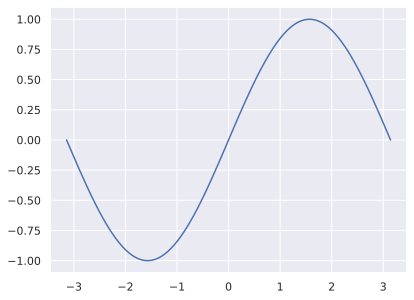

In [14]:
plt.plot(x,y)

**Task 2.2**: Randomly initialize the parameters of the polynomial.

In [15]:
a = torch.randn(())
b = torch.randn(())
c = torch.randn(())
d = torch.randn(())
model = lambda x: a + b * x + c * x ** 2 + d * x ** 3

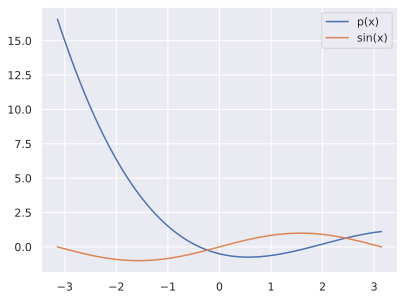

In [16]:
plt.plot(x, model(x).detach(), label='p(x)')
plt.plot(x, y, label='sin(x)')
plt.legend()

We can see that randomly guessing the parameters of our polynomial is not giving a good result. Our goal is to find a set of parameters that minimize the distance between $\hat{y_i} = p(x_i)$ and $y_i=f(x_i)$ at our given points. The function we want to minimize is also called loss function. For our task, a regression task, we use the mean squared error defined as:
\begin{align}
\mathrm{MSE}(\hat{y}, y) = \frac{1}{n} \sum_{i=1}^n \|\hat{y_i}- y_i\|^2
\end{align}

In other machine learning tasks like classifaction one would use a cross-entropy or binary-cross-entropy loss function instead of the MSE.

Our task now can be formulated as
\begin{align}
\mathrm{argmin}_{a,b,c,d \in \mathbb{R}} \mathrm{MSE}(p(\mathbf{x};a,b,c,d), \mathbf{y})
\end{align}

To minimize our loss function we use gradient descent. The idea is to walk to the minimum of our loss function

\begin{align}
a_{\mathrm{new}} = a - \lambda \nabla_a \mathrm{MSE}(\mathbf{\hat{y}}, \mathbf{y}).
\end{align}
We call $\lambda >0$ the learning rate.
To update the whole polynomial function we have to do this step for every parameter defining it.

To calculate the gradients we use one advantage of Pytorch - autograd. For that we have to activate the gradient tracking of our parameters.

In [17]:
a.requires_grad_()
b.requires_grad_()
c.requires_grad_()
d.requires_grad_()

tensor(-0.1566, requires_grad=True)

Now we can calculate the gradients of the loss with respect our parameters. This can be done by calling ``` a.grad``` after calculating the ```loss_val = loss(x,y)```  and calling ```loss_value.backward()```. 

**Attention:**
After the update one has to set the gradients again to be zero such that they don't accumulate their gradient values.
(This can be done by a.grad.zero_())

**Task 2.3**: Update the parameters of the polynomial. First set up a loss function. Then fill out the missing part in the updating loop.Now we can calculate the gradients of the loss with respect our parameters. This can be done by calling ``` a.grad``` after calculating the ```loss_val = loss(x,y)```  and calling ```loss_value.backward()```.

In [18]:
loss = lambda input, target: torch.mean((input-target).pow(2))

In [19]:
lr = 1e-3
for i in range(10000):
    loss_val = loss(y, model(x))
    loss_val.backward()
    
    with torch.no_grad():
        # here do the gradient descent step
        a -= lr * a.grad
        b -= lr * b.grad
        c -= lr * c.grad
        d -= lr * d.grad
        a.grad.zero_()
        b.grad.zero_()
        c.grad.zero_()
        d.grad.zero_()

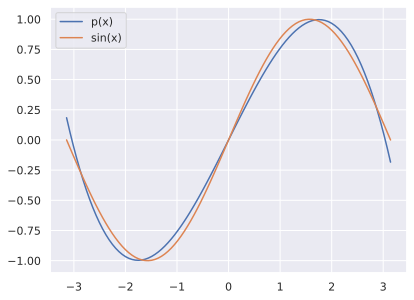

In [20]:
plt.plot(x, model(x).detach(), label='p(x)')
plt.plot(x, y, label='sin(x)')
plt.legend()

An optimizer porvided by ```torch.optim``` wraps around the whole updating step for each individual parameter. One has to select an optimzer, e.g. ```torch.optim.SGD(params= , lr= )``` for (stochastic) gradient descent, and give the parameters one wants to update to the optimizer as well as the learning rate.

By using an optimizer from ```torch.optim``` the code above can be rewritten
to:

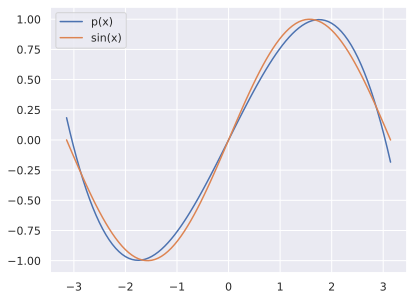

In [21]:
a = torch.randn((), requires_grad=True)
b = torch.randn((), requires_grad=True)
c = torch.randn((), requires_grad=True)
d = torch.randn((), requires_grad=True)
model = lambda x: a + b * x + c * x ** 2 + d * x ** 3

optimizer = torch.optim.SGD(params=[a,b,c,d], lr=1e-3)

for i in range(10000):
    loss_val = loss(model(x),y)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()

plt.plot(x, model(x).detach(), label='p(x)')
plt.plot(x, y, label='sin(x)')
plt.legend()

---
Check the documentation for more context on [optimizers](https://pytorch.org/docs/stable/optim.html) or [autograd](https://pytorch.org/docs/stable/autograd.html).

## 3. Network

In this section we want to construct a basic fully connected neural network (FNN) from scratch. A FNN consists of an input layer, hidden layers and an output layer.
The mathematical definition of a FNN with $L \in \mathbb{N}$ layers is given by
\begin{align*}
    \mathrm{a}^{[1]}&:=\textbf{x}\in \mathbb{R}^{n_1}
\end{align*}

\begin{align*}
z^{[l]}&:= W^{[l]}\mathrm{a}^{[l]}+b^{[l]}\in \mathbb{R }^{n_{l+1}},\quad l \in \{1,2,\dots,L-1\}
\end{align*}

\begin{align*}
\mathrm{a}^{[l+1]}&:= \alpha^{[l]}(z^{[l]}).
\end{align*}

We call $W$ the weight matrix, $b$ the bias and $\alpha$ the activation function. Below you can find a sketch of a FNN (a) with one hidden layer. For visualization purpose the bias and activation is left out in the sketch. In (b) you can see a close up on how one neuron of the hidden layer is influenced by the input neurons.

![image.png](./img/network.png)

To calculate $z$ the implementation in pytorch is done differently:
\begin{align*}
z^{[l]}&:= \mathrm{a}^{[l]}W^{[l]T}+b^{[l]}\in \mathbb{R }^{1 \times n_{l+1}},\quad l \in \{1,2,\dots,L-1\}
\end{align*}
The order of weight matrix $W$ multiplication is inverted by using the transpose of the weight matrix $W^T$. This is done to be able to stack multiple inputs ontop of each other and in that way. Multiple inputs stacked ontop of each other is called a batch. This way of feeding the input through the network speeds up the calculation.

Now we want to illustrate the functionality of such a network by teaching a network to behave like an XOR gate, which outputs 1 if only one of the inputs is close to one and 0 else.

In [22]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [23]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.8965, 0.0943]), tensor(1))


In [24]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

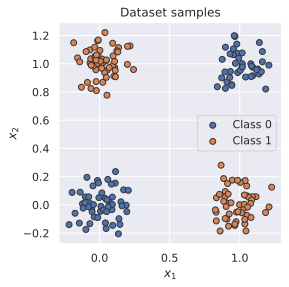

In [25]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [26]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [27]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)



Data inputs torch.Size([8, 2]) 
 tensor([[-0.0458,  0.9837],
        [ 1.2089, -0.0146],
        [ 1.0789,  0.9998],
        [-0.0627,  1.0352],
        [-0.0436,  0.0017],
        [ 1.0321,  0.0040],
        [ 1.0780,  0.0100],
        [ 1.0359, -0.1030]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 1, 0, 1, 1, 1])


**Task 3.1**:
Randomly initialize weights and biases with shapes corresponding to sketch.

In [28]:
#YOUR CODE HERE
W1 = torch.randn((4,2), requires_grad=True, device=device).T
b1 = torch.randn((4), requires_grad=True, device=device)
W2 = torch.randn((1,4), requires_grad=True, device=device).T
b2 = torch.randn((1), requires_grad=True, device=device)

activation_fn = torch.nn.Tanh()

**Task 3.2**: Define a function that calculates the forward process through our network using the defined weights and biases.

In [29]:
def xor_network(x):
    x = x@ W1 + b1
    x = activation_fn(x)
    x = x@W2 + b2
    return x

With the help of ```nn.Module``` the network can be refactored. The template of an ```nn.Module``` is:
```python
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

```
In the ```__init__(self)``` one initializes the network layers and in ```forward``` one defines how data is passed forward through the network.

**Task 3.3**: Refactor the network using the ```nn.Module```.

(Hint: The layer one needs is called ```nn.Linear```.)

In [30]:
class SimpleClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(2, 4)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(4, 1)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

Trainingloop for XOR network:

In [31]:
loss_bce = torch.nn.BCEWithLogitsLoss()
epochs = 100

dataset = XORDataset(size=2500)
data_loader = data.DataLoader(dataset, batch_size=128, shuffle=True)
model = SimpleClassifier().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-1)
for epoch in range(epochs):
    for data_inputs, data_labels in data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss_val = loss_bce(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss_val.backward()

        ## Step 5: Update the parameters
        optimizer.step()

In [32]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [33]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [34]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


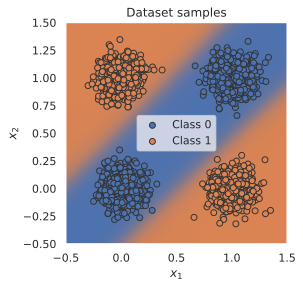

In [35]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

---
For more context check the documentation of [torch.nn](https://pytorch.org/docs/stable/nn.html).

## 4. Train a classifier

Using the Machine-Learning "Hello World" example - MNIST.
The MNIST dataset contains images of handwritten digits 0-9 with labels giving the corresponding digit seen in the image.  We now want to construct a simple fully connected neural network that predicts the digit seen in an image.

In [36]:
transform = transforms.ToTensor()
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True,
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

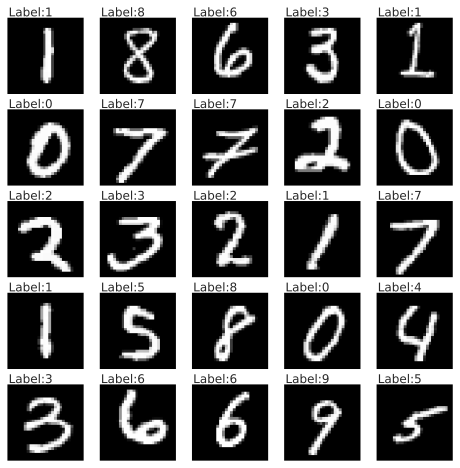

In [37]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.text(0, -1, 'Label:'+str(label))

plt.show()


**Task 4.1**: What is the dimension of the input data?

Answer: 

**Task 4.2**: What should the input dimension of your network be?

Answer: 

**Task 4.3**: What should the output dimension of your network be?

Answer: 

**Task 4.4**: Create a neural network with ```nn.Module```, that has one input, one hidden and one outputlayer. Choose suitable input and output dimensions for each layer. For your choice take into account the input shape and the numbers of classes we want to predict.

In [38]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.sequential_net = nn.Sequential(nn.Linear(28*28, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512,10))
    def forward(self, x):
        x = self.flatten(x)
        out = self.sequential_net(x)
        return out

net = Net().to(device)

**Task 4.5**: Choose a loss function and an optimizer. (Hint: This is a classifaction task)

In [39]:
# Choose your loss function wisely (Classifcation Task)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=net.parameters(), lr=1e-3)

**Task 4.6.** : Fill out the missing parts in the ```train_loop``` below.

In [40]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    progbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch, (X, y) in progbar:
        # Compute prediction and loss
        # move tensors to the used device
        X = X.to(device)
        y = y.to(device)

        # get the prediction of our model and calculate the loss
        pred = model(X)
        loss = loss_fn(pred, y)
        progbar.set_postfix({'Loss:': loss.item()})

        # Do the backpropagation step below
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, net, loss_function, optimizer, device)
    test_loop(test_loader, net, loss_function, device)
print("Done!")

Epoch 1
-------------------------------


  0%|          | 0/938 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 41.6%, Avg loss: 2.260082 

Done!


With the following code block you can check the output of your trained network compared to the label in the brackets.

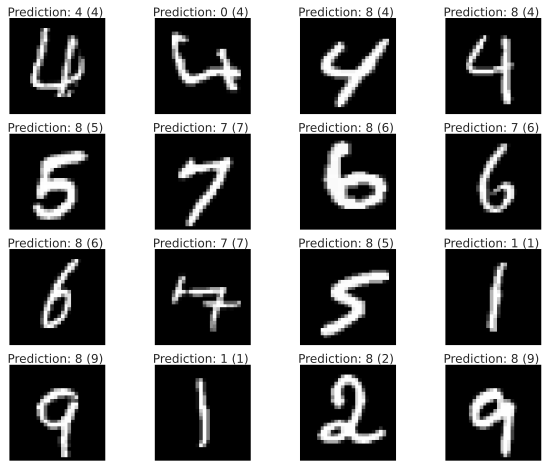

In [42]:
net = net.eval().cpu()

figure = plt.figure(figsize=(10, 8))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    prediction = net(img).argmax(1)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.text(-1, -1, f'Prediction: {prediction.item()} ({label})')
plt.show()

To save a trained model for later use, one can use the code below.

In [43]:
PATH = './mnist_classifier.pth'
torch.save(net.state_dict(), PATH)

To load the model from storage one first has to instatiate a network corresponding to the saved network structure. After that one can load the stored weights and biases from to the network.

In [44]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Extra Task
Try to optimize the accuracy for the classification task. Maybe have a look at convolutional neural networks (CNNs). Play around with different layers, learning rate, epoch number, optimizer ...